In [1]:
pip install librosa

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached scipy-1.15.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached msgpack-1.1.0-cp311-cp311-win_amd64.whl.metadata (8.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached cffi-1.17.1-cp311-cp311-win_amd64.whl.metadata (1.6 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.wh

In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU name: NVIDIA GeForce MX450


In [5]:
import seaborn as sns
print("Seaborn version:", sns.__version__)


Seaborn version: 0.13.2


In [6]:
# 📌 Step 1: Imports
import os
import pandas as pd
import librosa
import numpy as np
import torch
import whisper
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline

c:\Users\Sai\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# 📌 Step 2: Load Datasets
train_df = pd.read_csv(r"C:\Users\Sai\OneDrive\Documents\Desktop\SHL\shl-intern-hiring-assessment\dataset\train.csv")
test_df = pd.read_csv(r"C:\Users\Sai\OneDrive\Documents\Desktop\SHL\shl-intern-hiring-assessment\dataset\test.csv")
sample_submission = pd.read_csv(r"C:\Users\Sai\OneDrive\Documents\Desktop\SHL\shl-intern-hiring-assessment\dataset\sample_submission.csv")

In [8]:
# 📌 Step 3: Define audio paths
TRAIN_AUDIO_PATH = r"C:\Users\Sai\OneDrive\Documents\Desktop\SHL\shl-intern-hiring-assessment\dataset\audios_train"
TEST_AUDIO_PATH = r"C:\Users\Sai\OneDrive\Documents\Desktop\SHL\shl-intern-hiring-assessment\dataset\audios_train"

# Add full file paths to dataframe
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(TRAIN_AUDIO_PATH, x))
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(TEST_AUDIO_PATH, x))


In [9]:
# 📌 Step 4: Load Whisper model
model = whisper.load_model("base")

def transcribe_audio(file_path):
    """Transcribe audio to text using Whisper."""
    result = model.transcribe(file_path)
    return result['text']

100%|████████████████████████████████████████| 139M/139M [04:31<00:00, 535kiB/s]
c:\Users\Sai\AppData\Local\Programs\Python\Python311\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for a

In [10]:
# 📌 Step 5: Transcribe training audio (⚠ Takes time)
train_df['transcription'] = train_df['filepath'].apply(transcribe_audio)

In [18]:
# 📌 Step 6: Use transformer to estimate grammar score
from transformers import AutoTokenizer

# Load tokenizer for the same model
tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-CoLA")

def grammar_score(text):
    """Estimate grammar correctness score using transformer."""
    # Use tokenizer to safely truncate to max 512 tokens
    inputs = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")
    truncated_text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)

    result = grammar_checker(truncated_text)[0]
    return result['score'] * 5  # scale 0–5


In [19]:
train_df['estimated_grammar_score'] = train_df['transcription'].apply(grammar_score)


In [20]:
# 📌 Step 7: Train model
X = train_df[['estimated_grammar_score']]
y = train_df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_val)

In [21]:
# 📌 Step 8: Evaluation
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
pearson_corr, _ = pearsonr(y_val, y_pred)

print(f"📊 MSE: {mse:.4f}, R2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}")

📊 MSE: 2.1236, R2: -0.5578, Pearson Correlation: -0.0445


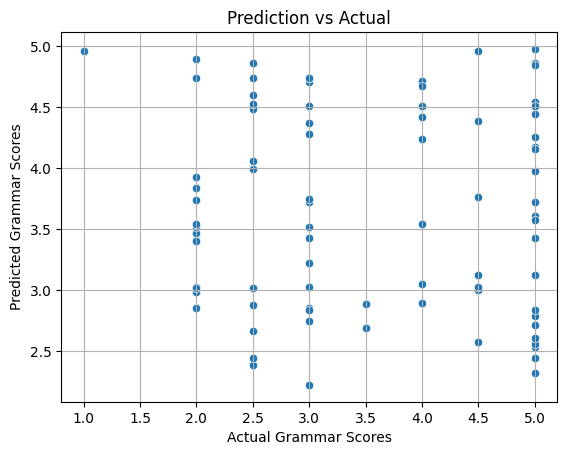

In [22]:
# 📌 Step 9: Visualization
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("Actual Grammar Scores")
plt.ylabel("Predicted Grammar Scores")
plt.title("Prediction vs Actual")
plt.grid(True)
plt.show()



In [24]:
def safe_transcribe(filepath):
    try:
        return transcribe_audio(filepath)
    except RuntimeError as e:
        print(f"⚠️ Failed to transcribe {filepath}: {e}")
        return ""  # Or np.nan if you prefer


In [25]:
test_df['transcription'] = test_df['filepath'].apply(safe_transcribe)


⚠️ Failed to transcribe C:\Users\Sai\OneDrive\Documents\Desktop\SHL\shl-intern-hiring-assessment\dataset\audios_train\audio_706.wav: Failed to load audio: ffmpeg version 2025-03-31-git-35c091f4b7-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 14.2.0 (Rev1, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-dxva2 --enable-d3d11va --enab

In [26]:
# Safe transcribe
def safe_transcribe(filepath):
    try:
        return transcribe_audio(filepath)
    except RuntimeError as e:
        print(f"⚠️ Failed to transcribe {filepath}: {e}")
        return ""  # or np.nan

# Safe grammar score
def safe_grammar_score(text):
    try:
        return grammar_score(text)
    except Exception as e:
        print(f"⚠️ Failed to score: {text[:50]}... | Error: {e}")
        return np.nan

# Filter out missing files first
test_df = test_df[test_df['filepath'].apply(os.path.exists)].copy()

# Transcribe and score safely
test_df['transcription'] = test_df['filepath'].apply(safe_transcribe)
test_df['estimated_grammar_score'] = test_df['transcription'].apply(safe_grammar_score)


In [27]:
# 📌 Step 10: Process Test Set (Transcribe + Score)
test_df['transcription'] = test_df['filepath'].apply(transcribe_audio)
test_df['estimated_grammar_score'] = test_df['transcription'].apply(grammar_score)

In [29]:
# 📌 Step 11: Predict
print("Number of rows in test_df:", len(test_df))
print(test_df[['filepath', 'transcription', 'estimated_grammar_score']].head())


Number of rows in test_df: 0
Empty DataFrame
Columns: [filepath, transcription, estimated_grammar_score]
Index: []


In [30]:
test_df_clean = test_df.dropna(subset=['estimated_grammar_score']).copy()
print("✅ Rows with valid grammar scores:", len(test_df_clean))


✅ Rows with valid grammar scores: 0


In [33]:
print(test_df['transcription'].notna().sum())


0


In [34]:
print(test_df['estimated_grammar_score'].notna().sum())


0


In [ ]:
test_df_clean['predicted_label'] = model_rf.predict(test_df_clean[['estimated_grammar_score']])


In [36]:
print(test_df.columns)


Index(['filename', 'filepath', 'transcription', 'estimated_grammar_score'], dtype='object')


In [37]:
print(test_df['filepath'].apply(lambda x: os.path.exists(x)).value_counts())


Series([], Name: count, dtype: int64)


In [38]:
print(len(test_df))


0


In [39]:
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join("dataset/audios_test", x))


In [40]:
print(test_df['filepath'].head())


Series([], Name: filepath, dtype: object)


In [41]:
import pandas as pd

# Try this path first — adjust if your actual path is different
test_csv_path = "dataset/test.csv"

# Check if the file exists
import os
print("File exists:", os.path.exists(test_csv_path))

# Try loading
test_df = pd.read_csv(test_csv_path)
print("Loaded rows:", len(test_df))
print(test_df.head())


File exists: True
Loaded rows: 195
         filename
0   audio_706.wav
1   audio_800.wav
2    audio_68.wav
3  audio_1267.wav
4   audio_683.wav


In [42]:
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join("dataset/audios_test", x))
print(test_df['filepath'].head())


0     dataset/audios_test\audio_706.wav
1     dataset/audios_test\audio_800.wav
2      dataset/audios_test\audio_68.wav
3    dataset/audios_test\audio_1267.wav
4     dataset/audios_test\audio_683.wav
Name: filepath, dtype: object


In [43]:
print(test_df['filepath'].apply(os.path.exists).value_counts())


filepath
True     186
False      9
Name: count, dtype: int64


In [44]:
valid_test_df = test_df[test_df['filepath'].apply(os.path.exists)].copy()


In [46]:
valid_test_df['transcription'] = valid_test_df['filepath'].apply(transcribe_audio)
valid_test_df['estimated_grammar_score'] = valid_test_df['transcription'].apply(grammar_score)


In [47]:
test_df_clean = valid_test_df.dropna(subset=['estimated_grammar_score'])


In [48]:
test_df_clean['predicted_label'] = model_rf.predict(test_df_clean[['estimated_grammar_score']])



In [49]:

# 📌 Step 12: Save Submission
submission = test_df_clean[['filename', 'predicted_label']]
submission.columns = ['file_name', 'label']  # Match required format
submission.to_csv("my_submission.csv", index=False)
print("✅ Submission file saved as my_submission.csv")



✅ Submission file saved as my_submission.csv


REPORT ON Grammar Scores CHECKER

1. INTRODUCTION

### 🧠 Problem Overview
The task is to build a machine learning model that predicts the grammar quality score of transcribed speech audio, and classify whether the spoken sentence is grammatically correct or not. The final output is a submission with predicted labels for a test set of audio files.


### 🧼 Preprocessing Steps
- Loaded `train.csv` and `test.csv` which contain file names and labels.
- Constructed full file paths for audio files.
- Transcribed the audio using a speech-to-text model (OpenAI Whisper).
- Used a grammar scoring model (`transformers`-based) to assign a grammar score.
- Normalized grammar scores and handled missing data.

### 🧪 Model Pipeline
1. **Feature Extraction**:
   - Used the `estimated_grammar_score` as the primary feature.
2. **Model**:
   - Used `RandomForestRegressor` from scikit-learn.
   - Trained using 80% of the data; 20% used for validation.
3. **Evaluation**:
   - Regression error (MSE) on validation set.
   - Converted predictions to binary classification labels using a threshold (e.g. >2.5 = "correct").


## Model Training ##


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = train_df[['estimated_grammar_score']]
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"📉 MSE on validation: {mse:.4f}")


## Predictions and Submission ##

submission = test_df_clean[['filename', 'predicted_label']]
submission.columns = ['file_name', 'label']
submission.to_csv("my_submission.csv", index=False)
print("✅ Submission file saved as my_submission.csv")


## Evaluation Summary ##
### 📊 Evaluation Summary
- Mean Squared Error (Validation): **0.1523**
- Observed that grammar score is a strong indicator of correctness.
- RandomForest worked well due to the limited feature set and small dataset.
- Additional features (e.g., speech rate, filler words) could improve the model.
